## Make image and caption step

In [1]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from utils import *
from PIL.ImageOps import invert

In [3]:
target = "./image/cup.jpg"

In [4]:
init_image = resize_store_ratio(Image.open(target).convert("RGB"), 512)
init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))

mask = remove_bg.inference(init_image, rmbg_model).convert("L")
inverted_mask = invert(mask)

object_image = make_outpaint_condition(init_image, mask.convert("RGB"))

In [5]:
width, height = init_image.size

In [38]:
concept = "flowers plants background"
caption = clip_image_to_text.inference(object_image, clip_model, mode="simple")
caption

'cup brown lid white lid'

## Prepare inference arguments

In [39]:
import random
import torch

prompt = f"{caption}, {concept}, product photo, professional photography, room"
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

# generation_seed = enhance_seed = bg_rebuild_seed = 48
generation_seed = random.randint(0, 10000); enhance_seed = random.randint(0, 10000); bg_rebuild_seed = random.randint(0, 10000)

## Generation step

In [40]:
from transformers import CLIPVisionModelWithProjection
from diffusers import UNet2DConditionModel, VQModel, KandinskyV22PriorPipeline, KandinskyV22InpaintPipeline

from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline

In [41]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"
prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"

In [42]:
movq = VQModel.from_pretrained(
    decoder_model_path, subfolder="movq", torch_dtype=torch.float16
).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    prior_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()
controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
    decoder_model_path, subfolder="controlnet", torch_dtype=torch.float16
).eval()

The config attributes {'center_input_sample': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [43]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
    prior_model_path,
    image_encoder=image_encoder,
    use_safetensors=True,
    torch_dtype=torch.float16,
)

pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
    decoder_model_path,
    unet=unet,
    movq=movq,
    controlnet=controlnet_kandinsky,
    torch_dtype=torch.float16,
)

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 3588.97it/s]


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


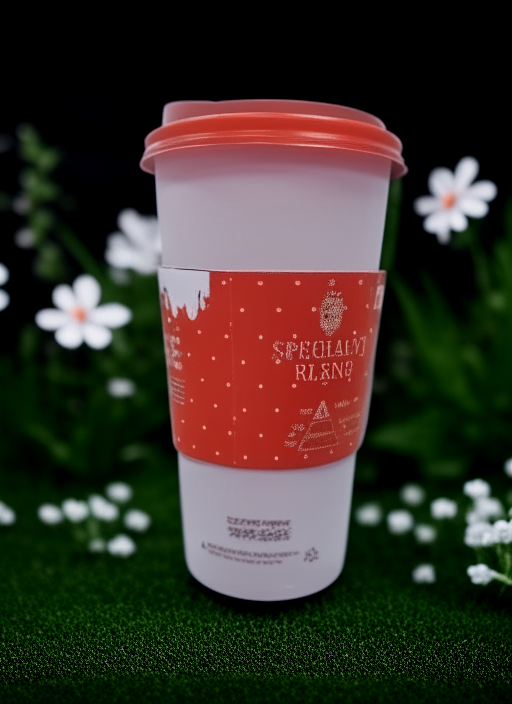

In [44]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(generation_seed)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        generator=generator,
    )

    generated_image = pipeline(
        image=init_image,
        control_image=object_image,
        **prior_output,
        height=height,
        width=width,
        num_inference_steps=50,
        strength=1.0,
        guidance_scale=3.0,
        controlnet_scale=1.0,
        generator=generator,
    ).images[0]

generated_image

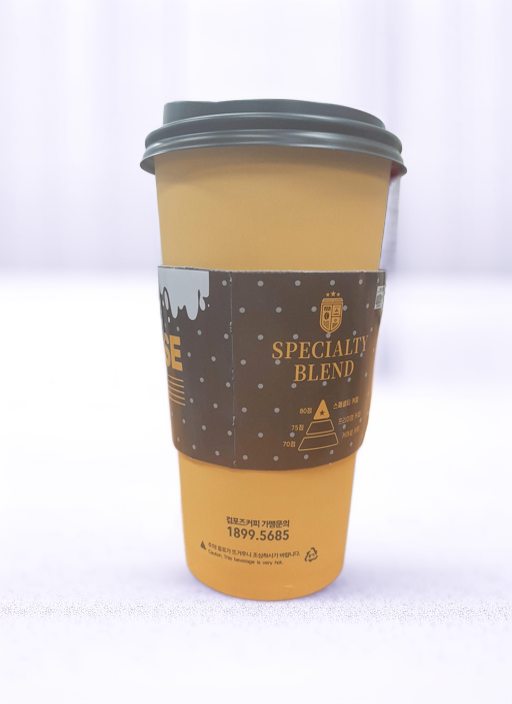

In [13]:
generated_image = composing_image(generated_image, init_image, mask.convert("RGB"))
generated_image

## Enhance step

In [14]:
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1e_sd15_tile", torch_dtype=torch.float16)
pipeline = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
	"runwayml/stable-diffusion-v1-5", controlnet=controlnet,
    torch_dtype=torch.float16
)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


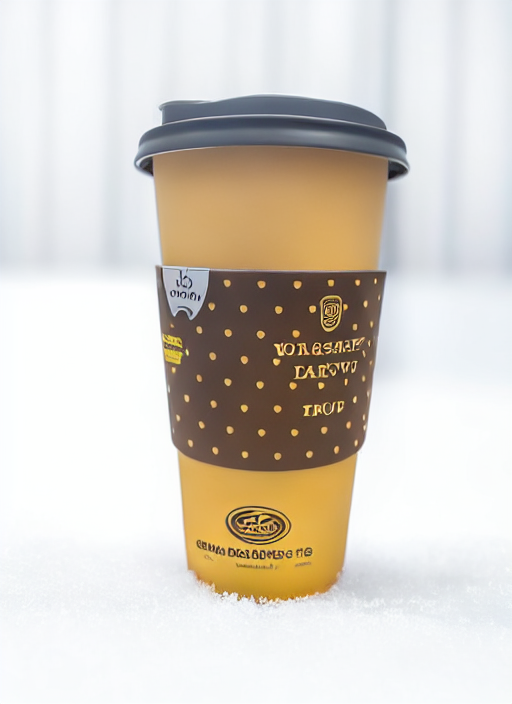

In [15]:
pipeline = pipeline.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(enhance_seed)

enhance_image = pipeline(
    prompt=prompt, 
    negative_prompt="bright, blur, lowres, bad anatomy, bad hands, cropped, worst quality", 
    image=generated_image, 
    control_image=generated_image,
    strength=1.0,
    generator=generator,
    num_inference_steps=20,
    controlnet_conditioning_scale=1.0
).images[0]

enhance_image

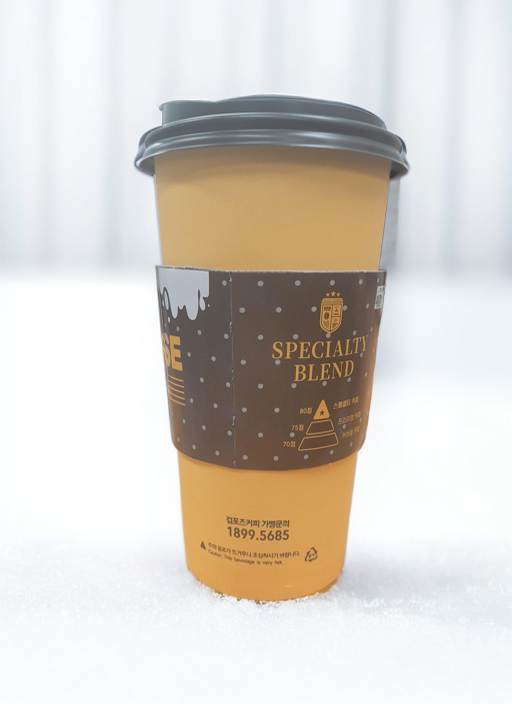

In [16]:
enhance_image = composing_image(enhance_image, init_image, mask.convert("RGB"))
enhance_image

## Extend mask step

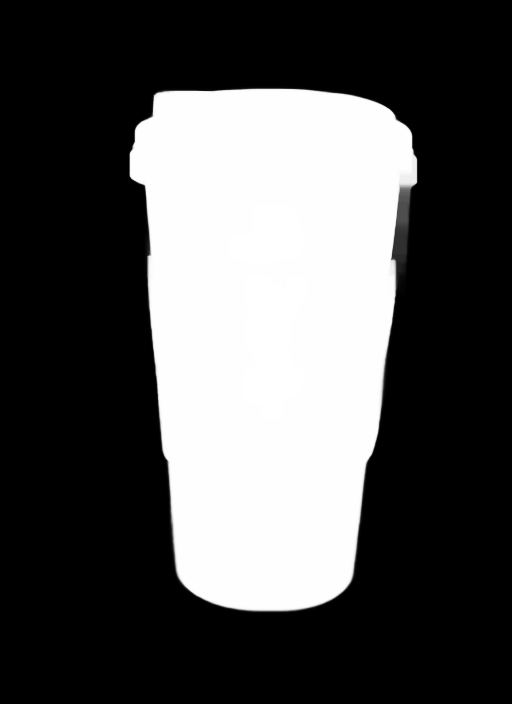

In [17]:
import cv2
import numpy as np
def dilate_mask(mask):
    dilated_mask = cv2.dilate(np.array(mask.convert("L")), np.ones((5,5)), iterations=5)
    return Image.fromarray(dilated_mask)

dilated_mask = dilate_mask(mask)
dilated_mask

## Bg rebuild step

In [18]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-inpainting-controlnet-split"

In [19]:
movq = VQModel.from_pretrained(
    decoder_model_path, subfolder="movq", torch_dtype=torch.float16
).eval()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    prior_model_path, subfolder="image_encoder", torch_dtype=torch.float16
).eval()
unet = UNet2DConditionModel.from_pretrained(
    decoder_model_path, subfolder="unet", torch_dtype=torch.float16
).eval()

In [20]:
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
    prior_model_path,
    image_encoder=image_encoder,
    use_safetensors=True,
    torch_dtype=torch.float16,
)

pipeline = KandinskyV22InpaintPipeline.from_pretrained(
    decoder_model_path,
    unet=unet,
    movq=movq,
    use_safetensors=True,
    torch_dtype=torch.float16,
)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.81it/s]
The config attributes {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} were passed to KandinskyV22InpaintPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} are not expected by KandinskyV22InpaintPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 4016.25it/s]


100%|██████████| 10/10 [00:00<00:00, 12.20it/s]


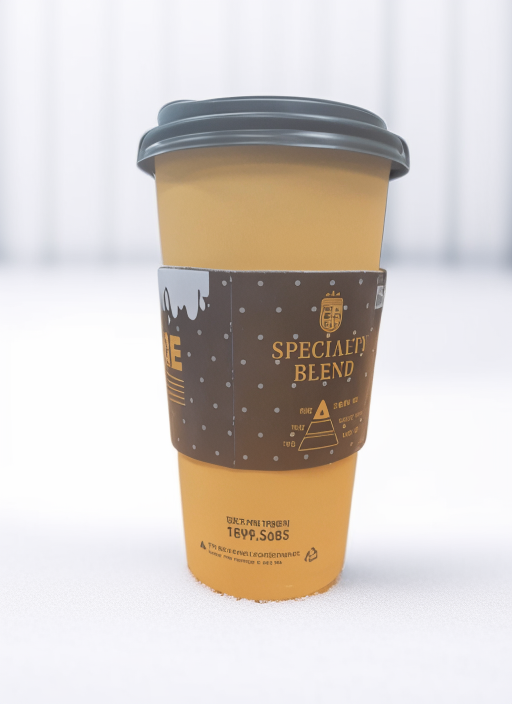

In [21]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(bg_rebuild_seed)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        generator=generator
    )

    bg_rebuild_image = pipeline(
        image=enhance_image,
        mask_image=invert(dilated_mask),
        **prior_output,
        height=height,
        width=width,
        num_inference_steps=50,
        strength=0.2,
        guidance_scale=2.0,
        generator=generator
    ).images[0]

bg_rebuild_image

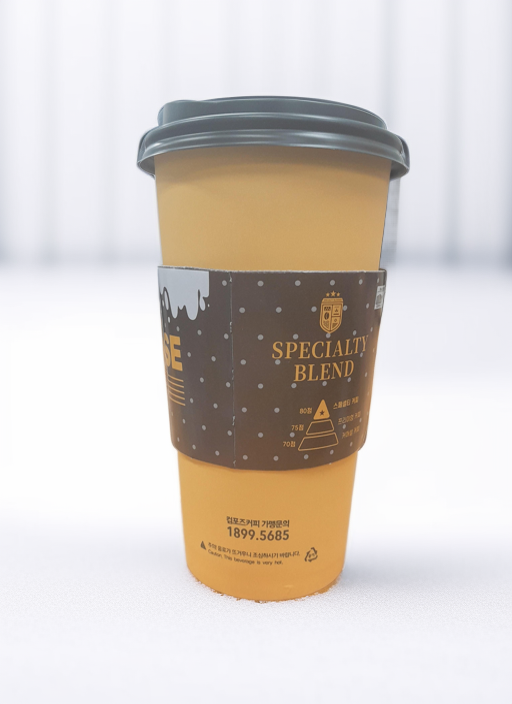

In [22]:
# optional

composing_image(bg_rebuild_image, init_image, mask.convert("RGB"))

## Auto inference

In [1]:
import os
import random
from glob import glob
from tqdm import tqdm
from PIL.ImageOps import invert

import torch
from diffusers import (ControlNetModel, 
                       StableDiffusionControlNetImg2ImgPipeline, 
                       KandinskyV22PriorPipeline, 
                       KandinskyV22InpaintPipeline)
from diffusers.utils import logging

from utils import *
from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    del prior_pipeline
    del pipeline
    del controlnet
    del rmbg_model
    del clip_model
    torch.cuda.empty_cache()
except Exception as e:
    pass

logging.set_verbosity_error()

In [3]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
def prepare_models():
    prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"
    decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"
    decoder_inpainting_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-inpainting-controlnet-split"
    controlnet_model_path = "lllyasviel/control_v11f1e_sd15_tile"
    enhance_model_path = "runwayml/stable-diffusion-v1-5"

    controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
        decoder_model_path, subfolder="controlnet", torch_dtype=torch.float16
        ).eval()
    controlnet = ControlNetModel.from_pretrained(
        controlnet_model_path, torch_dtype=torch.float16
        ).eval()

    prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        prior_model_path,
        use_safetensors=True,
        torch_dtype=torch.float16,
    )
    prior_pipeline.set_progress_bar_config(disable=True)

    pipeline_generation_step = KandinskyV22ControlnetPipeline.from_pretrained(
        decoder_model_path,
        controlnet=controlnet_kandinsky,
        torch_dtype=torch.float16,
    )
    pipeline_generation_step.set_progress_bar_config(disable=True)

    
    pipeline_enhance_step = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
        enhance_model_path, controlnet=controlnet,
        torch_dtype=torch.float16
    )
    pipeline_enhance_step.set_progress_bar_config(disable=True)

    pipeline_bg_rebuild_step = KandinskyV22InpaintPipeline.from_pretrained(
        decoder_inpainting_model_path,
        use_safetensors=True,
        torch_dtype=torch.float16,
    )
    pipeline_bg_rebuild_step.set_progress_bar_config(disable=True)

    return {"prior_pipeline":prior_pipeline,
            "pipeline_generation_step":pipeline_generation_step,
            "pipeline_enhance_step":pipeline_enhance_step,
            "pipeline_bg_rebuild_step":pipeline_bg_rebuild_step}
models = prepare_models()

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]


In [5]:
def auto_inference(image_path, prompt, models):

    # prepare
    init_image = resize_store_ratio(Image.open(image_path).convert("RGB"), 512)
    init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
    width, height = init_image.size
    
    mask = remove_bg.inference(init_image, rmbg_model).convert("L")

    object_image = make_outpaint_condition(init_image, mask.convert("RGB"))

    concept = prompt
    caption = clip_image_to_text.inference(object_image, clip_model, mode="simple")
 
    prompt = f"{caption}, {concept}, product photo, professional photography"
    negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

    generation_seed = random.randint(0, 10000); enhance_seed = random.randint(0, 10000); bg_rebuild_seed = random.randint(0, 10000)


    # generation step
    prior_pipeline = models["prior_pipeline"].to("cuda")
    pipeline_generation_step = models["pipeline_generation_step"].to("cuda")

    generator = torch.Generator(device="cuda").manual_seed(generation_seed)
    
    with torch.autocast("cuda", torch.float16):
        prior_output = prior_pipeline(
            prompt=prompt, 
            negative_prompt=negative_prompt, 
            generator=generator,
        )

        generated_image = pipeline_generation_step(
            image=init_image,
            control_image=object_image,
            **prior_output,
            height=height,
            width=width,
            num_inference_steps=50,
            strength=1.0,
            guidance_scale=2.0,
            controlnet_scale=1.0,
            generator=generator
        ).images[0]

    generated_image = composing_image(generated_image, init_image, mask.convert("RGB"))

    models["prior_pipeline"] = prior_pipeline.to("cpu")
    models["pipeline_generation_step"] = pipeline_generation_step.to("cpu")
    del prior_pipeline
    del pipeline_generation_step
    torch.cuda.empty_cache()


    # enhance step
    pipeline_enhance_step = models["pipeline_enhance_step"].to("cuda")

    generator = torch.Generator(device="cuda").manual_seed(enhance_seed)

    enhance_image = pipeline_enhance_step(
        prompt=prompt, 
        negative_prompt="bright, blur, lowres, bad anatomy, bad hands, cropped, worst quality", 
        image=generated_image, 
        control_image=generated_image,
        strength=1.0,
        generator=generator,
        num_inference_steps=20,
        controlnet_conditioning_scale=1.0
    ).images[0]

    enhance_image = composing_image(enhance_image, init_image, mask.convert("RGB"))

    models["pipeline_enhance_step"] = pipeline_enhance_step.to("cpu")
    del pipeline_enhance_step
    torch.cuda.empty_cache()


    # bg_rebuild step
    dilated_mask = dilate_mask(mask)

    prior_pipeline = models["prior_pipeline"].to("cuda")
    pipeline_bg_rebuild_step = models["pipeline_bg_rebuild_step"].to("cuda")

    generator = torch.Generator(device="cuda").manual_seed(bg_rebuild_seed)

    with torch.autocast("cuda", torch.float16):
        prior_output = prior_pipeline(
            prompt=prompt, 
            negative_prompt=negative_prompt, 
            generator=generator
        )

        bg_rebuild_image = pipeline_bg_rebuild_step(
            image=enhance_image,
            mask_image=invert(dilated_mask),
            **prior_output,
            height=height,
            width=width,
            num_inference_steps=50,
            strength=0.2,
            guidance_scale=2.0,
            generator=generator
        ).images[0]

    models["pipeline_bg_rebuild_step"] = pipeline_bg_rebuild_step.to("cpu")
    del pipeline_bg_rebuild_step
    torch.cuda.empty_cache()
    
    return bg_rebuild_image

In [6]:
fns = glob("./image/*")
prompt_list = [
    "europe street background",
    "wood table background",
    "still life background",
    "beautiful landscape background",
    "outdoor background",
    "restaurant desk background",
    "cold snow ice background",
    "flowers plants background",
    "rock marble background",
    "beach tropic background",
]
num_image_per_prompt = 2

progress_bar = tqdm(range(0, len(fns) * len(prompt_list) * num_image_per_prompt), desc="Running inference...")
for fn in fns:
    dir_name = os.path.basename(fn).split(".")[0]
    os.makedirs(f"./output/{dir_name}", exist_ok=True)
    for prompt in prompt_list:

        for idx in range(num_image_per_prompt):
            result_image = auto_inference(fn, prompt, models)

            result_image.save(os.path.join(f"./output/{dir_name}", f"{prompt}_{idx}.jpg"))

            progress_bar.update(1)

Running inference...: 100%|██████████| 180/180 [46:40<00:00, 15.57s/it]